# Anomaly Detection
---

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(context="notebook", style="white")
sns.set(context="notebook", style="white", palette="dark")
#sns.set(context="notebook", style="white", palette="RdBu")

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats
#from sklearn.cross_validation import train_test_split

## Load Example Dataset
---
We start this exercise by using a small dataset that is easy to visualize. Our example case consists of 2 network server statistics across several machines:   the latency and throughput of each machine.This exercise will help us find possibly faulty (or very fast) machines.

In [342]:
# Visualizing example dataset for outlier detection.
mat = sio.loadmat('ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [343]:
# The following command loads the dataset. 
# You should now have the variables X, Xval, yval in your environment
X = mat.get('X')
Xval = mat.get('Xval')
yval = mat.get('yval')
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

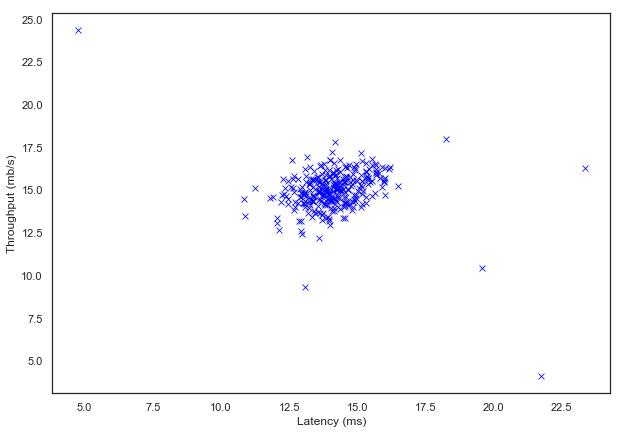

In [5]:
# Visualize the example dataset
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X[:,0], X[:,1], marker='x', c='blue', linewidth=0.8, s=35)
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')
plt.show()

# Estimate the dataset statistics
---
For this exercise, we assume a Gaussian distribution for the dataset.  
  
We first estimate the parameters of our assumed Gaussian distribution, then compute the probabilities for each of the points and then visualize both the overall distribution and where each of the points falls in terms of that distribution.

### Anomaly detection algorithm
#### 1. Multivariate Gaussian (Normal) distribution
1. Choose features $x_j$ that you think might be indicative of anomalous examples.
2. Fit parameters $\mu_1,...,\mu_n,\sigma_1^2,...,\sigma_n^2$  
$\mu_j = \frac{1}{m}\sum\limits_{i=1}^{m}x_j^{(i)}$  
$\sigma_j^2=\frac{1}{m}\sum\limits_{i=1}^{m}\big(x_j^{(i)} - \mu_j\big)^2$  
3. Given new example $x$, compute $p(x)$:  
$p(x)=\prod\limits_{j=1}^{n}p\big(x_j;\mu_j,\sigma_j^2\big) = \prod\limits_{j=1}^{n} \frac{1}{\sqrt{2\pi}\sigma_j} exp\big(-\frac{(x_j-\mu_j)^2}{2\sigma_j^2}\big)$  
Anomaly if $p(x) < \varepsilon$  

#### 2. Multivariate Gaussian (Normal) distribution
Parameters $\mu, \Sigma$  
$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}} exp \Big(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\Big)$  
Parameter fitting: Given training set $\big\{x^{(1)},x^{(2)},...,x^{(m)}\big\}$  
$\mu = \frac{1}{m}\sum\limits_{i=1}^{m}x^{(i)}$  
$\Sigma=\frac{1}{m}\sum\limits_{i=1}^{m}\big(x^{(i)}-\mu\big)\big(x^{(i)}-\mu\big)^T$



```Octave
%数据初始化
X =[13 105;19 87;50 90;16 93;18 100;21 85;11 90]   %shape=(7*2)
X = X - mean(X)    %数据减去本列均值
X'
%协方差
C = (X'*X)/(length(X)-1)
%标准差
S = sum(X.^2)/(length(X)-1)
%所以正对角线上的数据与方差一致，而反对角线上数据标准不同列之间的相关性。 
%正数：正相关 
%负数：负相关 
%零：不相关
% https://blog.csdn.net/weixin_40920228/article/details/80574332
```

X =

    13   105
    19    87
    50    90
    16    93
    18   100
    21    85
    11    90

X =

   -8.14286   12.14286
   -2.14286   -5.85714
   28.85714   -2.85714
   -5.14286    0.14286
   -3.14286    7.14286
   -0.14286   -7.85714
  -10.14286   -2.85714

ans =

   -8.14286   -2.14286   28.85714   -5.14286   -3.14286   -0.14286  -10.14286
   12.14286   -5.85714   -2.85714    0.14286    7.14286   -7.85714   -2.85714

C =

   173.810   -26.976
   -26.976    51.810

S =

   173.810    51.810


In [6]:
# Visualizing Gaussian fit.

In [62]:
# This function estimates the parameters of a Gaussian distribution using the data in X. 
# The input X is the dataset with each n-dimensional data point in one row
# The output is an n-dimensional vector mu, the mean of the data set and the variances sigma^2, an n x 1 vector
def estimateGaussian(X):
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    Sigma = np.diag(sigma2)
    Sigma_covariance = (X - mu).T @ (X - mu) / X.shape[0]
    return mu, sigma2, Sigma, Sigma_covariance

In [344]:
# Estimate my and sigma2
# mu = [14.11222578, 14.99771051]
# sigma2 = [1.83263141, 1.70974533]
mu, sigma2, Sigma, Sigma_covariance = estimateGaussian(X); 
mu, sigma2, Sigma, Sigma_covariance, np.cov(X.T)

(array([14.11222578, 14.99771051]),
 array([1.83263141, 1.70974533]),
 array([[1.83263141, 0.        ],
        [0.        , 1.70974533]]),
 array([[ 1.83263141, -0.22712233],
        [-0.22712233,  1.70974533]]),
 array([[ 1.83862041, -0.22786456],
        [-0.22786456,  1.71533273]]))

In [71]:
def multivariateGaussian(X, mu, sigma):
    # To computes the probability density function of the examples X 
    # under the multivariate gaussian distribution parameters mu and Sigma2. 
    # If Sigma2 is a matrix, it is treated as the covariance matrix. 
    # If Sigma2 is a vector, it is treated as the sigma^2 values of the variances 
    # in each dimension (a diagonal covariance matrix)

    # Compute the determinant of A.

    p_numerator = (X - mu) @ np.linalg.pinv(sigma)
    p_numerator = np.multiply(p_numerator, X - mu)
    p_numerator = np.sum(p_numerator, axis=1)
    p_numerator = np.exp(-0.5 * p_numerator)

    p_denominator = np.power(2 * np.pi, len(mu) / 2)
    p_denominator = p_denominator * np.power(np.linalg.det(sigma), 0.5)
    
    p = p_numerator / p_denominator

    return p

In [79]:
#  Returns the density of the multivariate normal at each data point (row) of X
p = multivariateGaussian(X, mu, Sigma)
#p = multivariateGaussian(X, mu, Sigma_covariance)

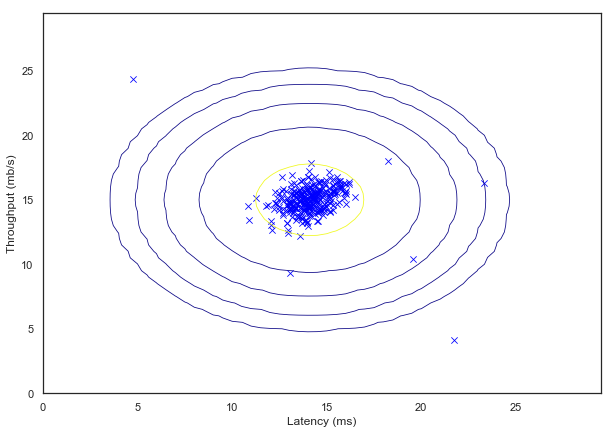

In [198]:
# Visualize the fit

# Visualize the example dataset
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X[:,0], X[:,1], marker='x', c='blue', linewidth=0.8, s=40)
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')

x, y = np.mgrid[0:30:0.5, 0:30:0.5]
z = x.copy()
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = multivariateGaussian(np.array([[x[i, j], y[i, j]]]),mu, Sigma)
        #z[i, j] = multivariateGaussian(np.array([[x[i, j], y[i, j]]]),mu, Sigma_covariance)
ax.contour(x, y, z, [1.0e-14, 1.0e-11, 1.0e-08, 1.0e-05, 1.0e-02], linewidths=0.8, cmap='plasma')
plt.show()

# Find Outliers
---
Now you will find a good epsilon threshold using a cross-validation set probabilities given the estimated Gaussian distribution

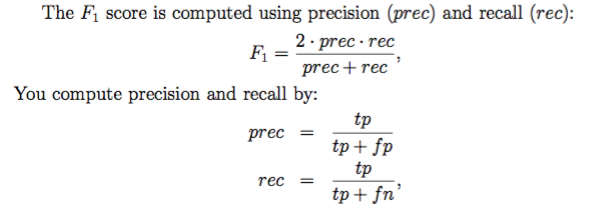

In [345]:
def select_threshold(yval, pval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    stepsize = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), stepsize):
        
        #tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        #fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        #fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        tp = np.sum(np.floor((np.array([pval<epsilon]).T + yval) / 2))
        fp = np.sum(np.ceil((np.array([pval<epsilon]).T - yval) / 2))
        fn = -np.sum(np.floor((np.array([pval<epsilon]).T - yval) / 2))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [346]:
pval = multivariateGaussian(Xval, mu, Sigma)
epsilon, F1 = select_threshold(yval, pval)

c:\workspace\installed\python\python36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [349]:
# you should see a value epsilon of about 8.99e-05)
# you should see a Best F1 value of  0.875000)
print('Best epsilon found using cross-validation: ' + str(epsilon));
print('Best F1 on Cross Validation Set: ' + str(F1));
print('\t(you should see a value epsilon of about 8.99e-05)');
print('\t(you should see a Best F1 value of  0.875000)');

Best epsilon found using cross-validation: 8.990852779269496e-05
Best F1 on Cross Validation Set: 0.8749999999999991
	(you should see a value epsilon of about 8.99e-05)
	(you should see a Best F1 value of  0.875000)


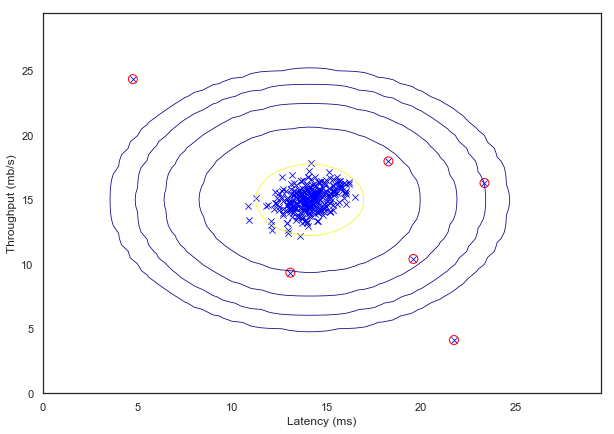

In [317]:
# Visualize the fit

# Find the outliers in the training set and plot the
outliers = np.nonzero(p<epsilon)

# Visualize the example dataset
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X[:,0], X[:,1], marker='x', c='blue', linewidth=0.8, s=40)
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')

x, y = np.mgrid[0:30:0.5, 0:30:0.5]
z = x.copy()
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = multivariateGaussian(np.array([[x[i, j], y[i, j]]]),mu, Sigma)
        #z[i, j] = multivariateGaussian(np.array([[x[i, j], y[i, j]]]),mu, Sigma_covariance)
ax.contour(x, y, z, [1.0e-14, 1.0e-11, 1.0e-08, 1.0e-05, 1.0e-02], linewidths=0.8, cmap='plasma')
ax.scatter(X[outliers, 0], X[outliers, 1], marker='o', c='', edgecolors='red', linewidth=1, s=80)
plt.show()

# Multidimensional Outliers
---
We will now use the code from the previous part and apply it to a harder problem in which more features describe each datapoint and only some features indicate whether a point is an outlier.

In [318]:
mat = sio.loadmat('ex8data2.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [319]:
# The following command loads the dataset. 
# You should now have the variables X, Xval, yval in your environment
X = mat.get('X')
Xval = mat.get('Xval')
yval = mat.get('yval')
X.shape, Xval.shape, yval.shape

((1000, 11), (100, 11), (100, 1))

In [320]:
# Apply the same steps to the larger dataset
mu, sigma2, Sigma, Sigma_covariance = estimateGaussian(X); 
mu, sigma2, Sigma, Sigma_covariance, np.cov(X.T)

(array([  4.93940034,  -9.63726819,  13.81470749, -10.4644888 ,
         -7.95622922,  10.19950372,  -6.01940755,   7.96982896,
         -6.2531819 ,   2.32451289,   8.47372252]),
 array([60.97489373, 53.20572186, 58.51546272, 84.20403725, 65.26859177,
        89.57487757, 55.63349911, 87.16233783, 29.62926829, 70.7852052 ,
        50.50356719]),
 array([[60.97489373,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        , 53.20572186,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        , 58.51546272,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        , 84.20403725,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.

In [337]:
# Training set 
p = multivariateGaussian(X, mu, Sigma);
#p = multivariateGaussian(X, mu, Sigma_covariance);

In [338]:
# Cross-validation set
pval = multivariateGaussian(Xval, mu, Sigma);
#pval = multivariateGaussian(Xval, mu, Sigma_covariance);

In [339]:
# Find the best threshold
epsilon, F1 = select_threshold(yval, pval)

c:\workspace\installed\python\python36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [340]:
# you should see a value epsilon of about 1.38e-18
# you should see a Best F1 value of 0.615385
print('Best epsilon found using cross-validation: ' + str(epsilon));
print('Best F1 on Cross Validation Set: ' + str(F1));
print('\t(you should see a value epsilon of about 1.38e-18)');
print('\t(you should see a Best F1 value of 0.615385)');
print('# Outliers found: ' + str(sum(p < epsilon)))

Best epsilon found using cross-validation: 1.3772288907613581e-18
Best F1 on Cross Validation Set: 0.6153846153846146
	(you should see a value epsilon of about 1.38e-18)
	(you should see a Best F1 value of 0.615385)
# Outliers found: 117
